# Introduction to a Convolutional NN - classifying handwritten numbers:

For a long time, images were inaccesible to computers and ML algorithms. However, at the turn of the century very fast development - a slow revolution - happened, and the usage of Convolutional Neural Networks (CNNs) became computationally feasible. The advent of Graphical Processing Units (GPUs) also help propel the sharp rise in ML image analysis capabilities.

Through first the MNIST database (1998-2004), and then the PASCAL (2005-2010) and ImageNet (2010-2017) competitions, CNN code developed to become capable of classifying the content of images. The following is an exercise, which uses the famous MNIST dataset, containing about 70000 images of handwritten digits, reduced (and anti-aliased) to 28-by-28 pixel black-and-write images.

The CNN applied filters to these images, and then concatenates (i.e. "boils down") the images to lower resolution. This process is repeated, and finally the resulting pixel values are fed to a normal Neural Network, and made to provide an output, which lowers the loss function (in this case getting the value of the digit right). Through backpropagation, the filter values and the NN parameters are optimised, and thus in the end, the CNN becomes capable of evaluating images.

The code and comments below is meant to be part illustration, part exercise. Note that it takes a few minutes to run (unless you have a GPU).

***

Authors: Troels Petersen (with input from Carl Johnsen)

Email: petersen@nbi.dk

Date: 5th of May 2024 (latest version)

In [1]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# Keras documentation can be found on keras.io:
import keras
from keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


# Load and prepare the MNIST dataset

The MNIST dataset is a "famous" image dataset from Yann Lecun et al. consisting of 60000 training and 10000 testing 28x28 gray scale images. Many different methods (mainly CNNs) have been applied to this dataset, which is excellent for "fast" CNN learning, as the images are small and the sample size just about right.

In [2]:
# the data, split between train and testval sets
(train_images, train_labels), (testval_images, testval_labels) = mnist.load_data()

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
val_images, test_images, val_labels, test_labels = train_test_split(testval_images, testval_labels, test_size=0.2, random_state=13052020)

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 28, 28 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 10
train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# Inspect data shapes

In [3]:
print("Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)
print("Test set:")
print(" > images:", test_images.shape)
print(" > labels:", test_labels.shape)

Training set:
 > images: (60000, 28, 28, 1)
 > labels: (60000, 10)
Validation set:
 > images: (8000, 28, 28, 1)
 > labels: (8000, 10)
Test set:
 > images: (2000, 28, 28, 1)
 > labels: (2000, 10)


# Verify first 5 images in each split dataset:

It is always a good idea to inspect your data.

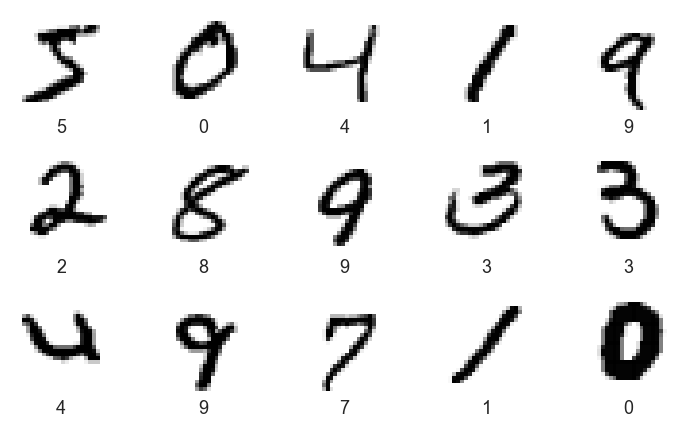

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))
for i in range(5):

    # train
    ax[0,i].imshow(train_images[i].reshape(28,28), cmap=plt.cm.binary)
    ax[0,i].set_xlabel(np.argmax(train_labels[i]), fontsize=18)
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([]); ax[0,i].grid(False)
    # val
    ax[1,i].imshow(val_images[i].reshape(28,28), cmap=plt.cm.binary)
    ax[1,i].set_xlabel(np.argmax(val_labels[i]), fontsize=18)
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([]); ax[1,i].grid(False)
    # test
    ax[2,i].imshow(test_images[i].reshape(28,28), cmap=plt.cm.binary)
    ax[2,i].set_xlabel(np.argmax(test_labels[i]), fontsize=18)
    ax[2,i].set_xticks([]); ax[2,i].set_yticks([]); ax[2,i].grid(False)
    
plt.tight_layout()
plt.show()

# Check for (un)balanced data:

Test if there is roughly an even number of digits.

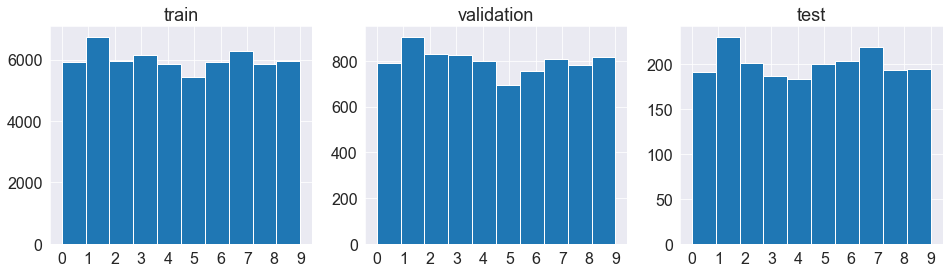

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(np.argmax(train_labels, axis=1).flatten()); ax[0].set_title('train', fontsize=18); ax[0].set_xticks(np.arange(10)); ax[0].tick_params(axis='both', which='major', labelsize=16);
ax[1].hist(np.argmax(val_labels, axis=1).flatten()); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks(np.arange(10)); ax[1].tick_params(axis='both', which='major', labelsize=16);
ax[2].hist(np.argmax(test_labels, axis=1).flatten()); ax[2].set_title('test', fontsize=18); ax[2].set_xticks(np.arange(10)); ax[2].tick_params(axis='both', which='major', labelsize=16);
plt.show()

# Create architecture

**Exercise:** See if you can also draw the below architecture, making it clear to others what exactly is done/used.

In [6]:
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

# Compile and train model:

In [7]:
# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=256,
                    epochs=3,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Train on 60000 samples, validate on 8000 samples
Epoch 1/3
60000/60000 [==============================] - 31s 524us/step - loss: 0.2608 - categorical_accuracy: 0.9184 - val_loss: 0.0546 - val_categorical_accuracy: 0.9821
Epoch 2/3
60000/60000 [==============================] - 33s 553us/step - loss: 0.0716 - categorical_accuracy: 0.9777 - val_loss: 0.0558 - val_categorical_accuracy: 0.9822
Epoch 3/3
60000/60000 [==============================] - 34s 561us/step - loss: 0.0508 - categorical_accuracy: 0.9844 - val_loss: 0.0381 - val_categorical_accuracy: 0.9880


# Inspect learned kernels:

The kernels (also called filters or masks) are the (typically 3x3) matrices that are convoluted across the input image to produce output images, which are then concatenated. Inspecting them can (sometimes?) give an idea of what goes on (edge detection, sharpen, blurring, etc.) in the different layers, see [Wikipedia on Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing)).

1st convolution layer:


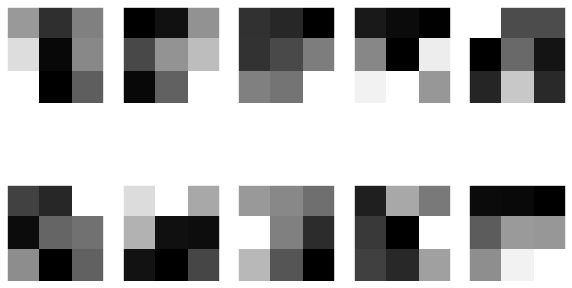

2nd convolution layer:


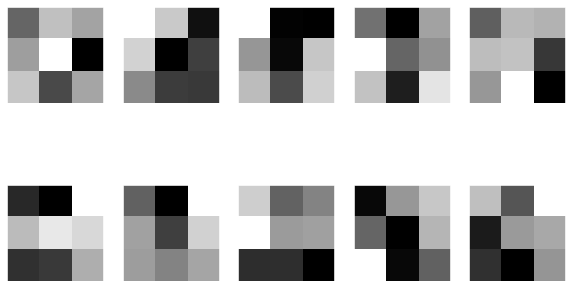

In [8]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

print('1st convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

print('2nd convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

# Evaluate training process

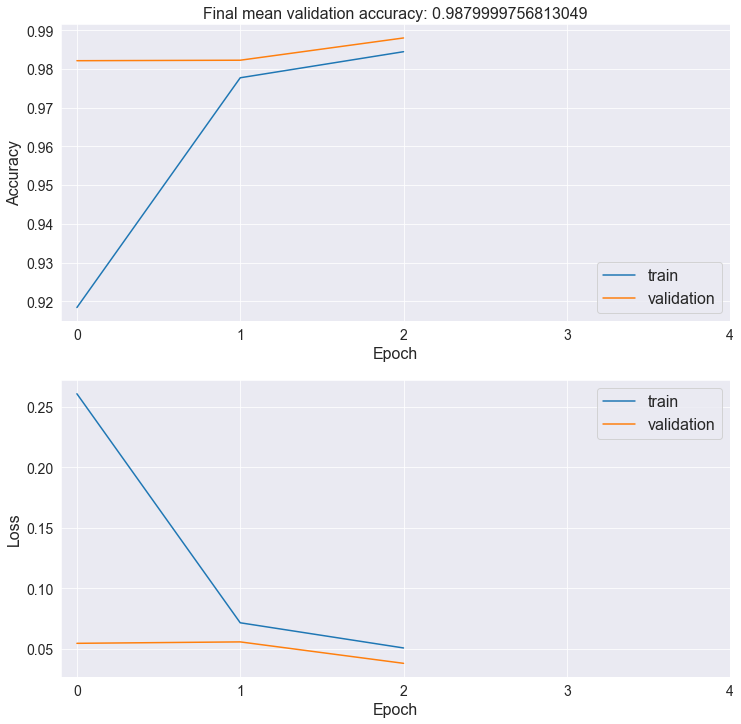

In [9]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

# Inference

In [10]:
# Using until now unseen data:
predicted_prob = model.predict(test_images)
predictions = np.argmax(predicted_prob, axis=1)

In [11]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1), predictions=predictions, num_classes=num_classes)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate

Confusion Matrix:  tf.Tensor(
[[191   0   0   0   0   0   0   0   0   0]
 [  0 230   0   0   0   0   0   0   0   0]
 [  0   0 201   0   0   0   0   0   0   0]
 [  0   0   0 185   0   0   0   0   1   0]
 [  0   0   0   0 182   0   0   0   1   0]
 [  1   0   0   3   0 192   1   1   1   1]
 [  3   0   0   0   0   1 197   0   2   0]
 [  0   0   1   0   0   0   0 216   1   1]
 [  0   0   4   0   0   1   0   1 187   0]
 [  2   0   0   0   0   0   0   1   0 191]], shape=(10, 10), dtype=int32)


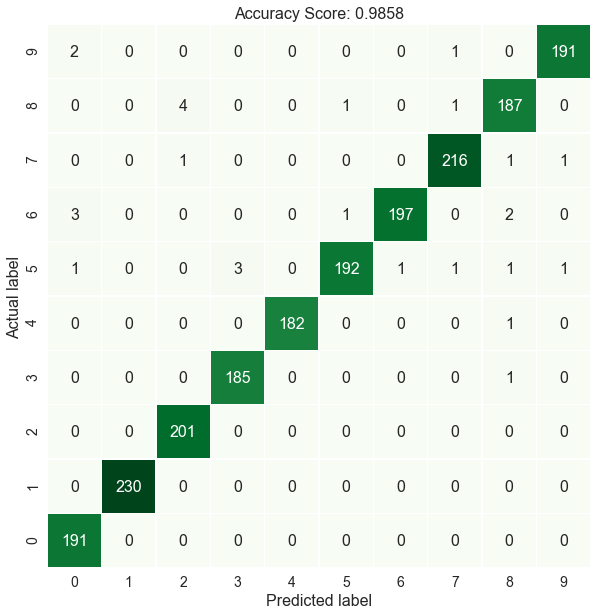

Correct: 1972/2000
Wrong: 28/2000


In [12]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

# Inspection of predictions

### Correctly predicted images

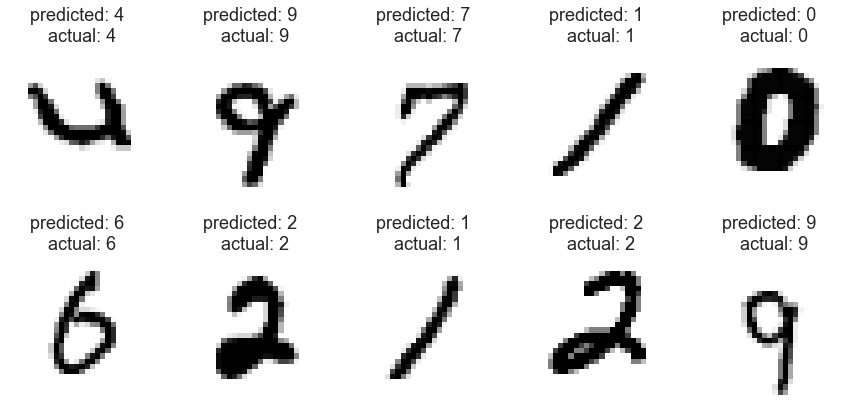

In [13]:
# show first 10 images that were correctly predicted
correct_idx = np.where(predictions == np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[correct_idx[i]], np.argmax(test_labels, axis=1)[correct_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Wrongly predicted images

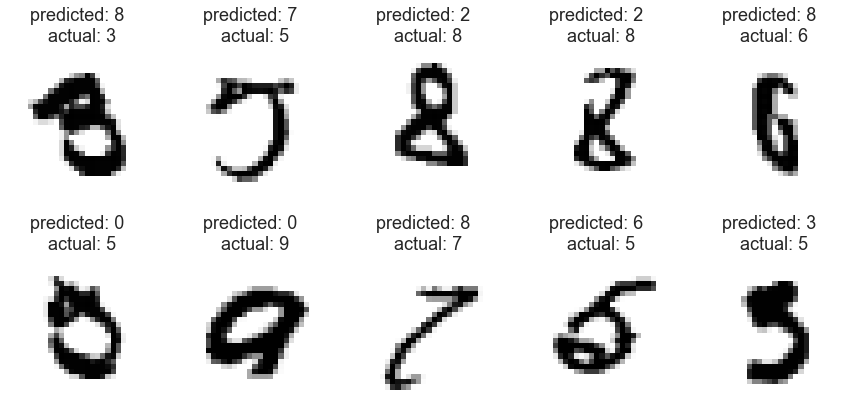

In [14]:
# Show first 10 images that were wrongly predicted:
wrong_idx = np.where(predictions != np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[wrong_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[wrong_idx[i]], np.argmax(test_labels, axis=1)[wrong_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

## Exercise Questions:

1. Read through the code, understand each part, and draw the current architecture of the CNN.
2. How many parameters does you CNN model have?
3. Remind yourself (and your peers?) why the validation loss might be lower than the training loss?
4. From the confusion matrix, what are the most likely mistakes made?
5. Try to change the network architecture and other hyper parameters to see, if you can get a better accuracy?
6. How large is the test set used? And what precision do you reach? Do you see any challenges with this?
7. Discuss the correctly but in particular the **wrongly predicted** images with your peers.<br>
   What might be the main reason for the wrong predictions, and can they be remedied?

## Learning points:

From this exercise - which is partly for illustration, but also great for "playing around" with CNNs - you should have learned the following:
1. CNNs are the goto model for image analysis.
2. They work by convoluting the input images with kernels that are trained to recognise certain features in the image (not unlike neurons in an ordinary NN).
2. Your CNN considerations should include:
     - Sample and image sizes (enough training and testing data?),
     - CNN architecture (size and number of kernels),
     - Batch size (optimising how fast you converge), and
     - if you need GPUs for the problem!
3. CNNs can be implemented in (Keras) TensorFlow (easiest) and PyTorch (harder but more versatile).

## Final remarks:

This reflects a very simple and crude CNN model. Since MNIST is a relatively straightforward dataset, using a "larger" (i.e. full scale) CNN model, you should expect even better results! **However, the real test is, if you can apply the above approach to another more complicated dataset**.

Also, as the size of the problem grows (larger images!!!), the use of GPUs becomes necessary. They are typically a factor 20-50 faster.